<a href="https://colab.research.google.com/github/woo2201/sampleCases/blob/reservior/AmericanExpress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/dataset/AmericanExpress/

/content/drive/MyDrive/dataset/AmericanExpress


In [3]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
path = "/content/drive/MyDrive/dataset/AmericanExpress/"
filenames = glob.glob(path + "*.ftr")

In [5]:
%%time
test = pd.read_feather(filenames[1])
train = pd.read_feather(filenames[0])

CPU times: user 20.8 s, sys: 33.6 s, total: 54.4 s
Wall time: 43.8 s


In [6]:
(train.shape, test.shape)

((5531451, 191), (11363762, 190))

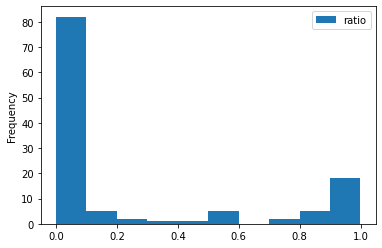

In [9]:
(
    train
        .isna()
        .mean()
        .reset_index(name = 'ratio')
        .query('ratio != 0')
        .plot(kind = 'hist')
)

In [8]:
train.target.value_counts()

0    4153582
1    1377869
Name: target, dtype: int64

In [29]:
delinquency_cols = ['customer_ID', 'S_2'] + [col for col in train.columns if col.startswith('D_')]
spend_cols = ['customer_ID'] + [col for col in train.columns if col.startswith('S_')]
payment_cols = ['customer_ID', 'S_2'] + [col for col in train.columns if col.startswith('P_')]
balance_cols = ['customer_ID', 'S_2'] + [col for col in train.columns if col.startswith('B_')]
risk_cols = ['customer_ID', 'S_2'] + [col for col in train.columns if col.startswith('R_')]

In [32]:
import seaborn as sns
df = train[spend_cols].sample(30000).drop(['customer_ID'], axis = 1).dropna()
sns.set_theme(style = 'ticks')
sns.pairplot(data = df, hue = 'S_2')

TypeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe128bd8e60> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7fe128be14d0> (for post_execute):


KeyboardInterrupt: ignored

Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

In [ ]:
for col in [delinquency_cols, spend_cols, payment_cols, balance_cols, risk_cols]:
    print(len(col))

98
24
5
42
30


In [ ]:
train.select_dtypes(include = ['category']).head(3)

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
0,CR,,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0
1,CR,,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0
2,CR,,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,0.0


In [ ]:
train.select_dtypes(include = ['object']).head(3)

,customer_ID
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...


In [ ]:
train.select_dtypes(include = ['number']).head(3)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,0.113159,NaN,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,0.123047,NaN,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.001460
2,0.608887,0.003326,0.016388,1.004883,0.000114,0.267090,0.004196,0.004192,0.125366,NaN,...,NaN,NaN,NaN,0.000074,0.002113,0.004658,NaN,0.003155,0.002155,0.006481


In [ ]:
train.select_dtypes(include = ['category']).describe()

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,D_126
count,11363762,11363762,1349834.0,11015266.0,11360845.0,11360845.0,11079521.0,11079521.0,11079521.0,11079521.0,11281361.0
unique,6,4,1.0,6.0,3.0,7.0,2.0,2.0,7.0,2.0,3.0
top,CO,O,1.0,6.0,0.0,2.0,1.0,0.0,-1.0,0.0,1.0
freq,8429213,5993483,1349834.0,5623121.0,9618034.0,4133804.0,6957846.0,11048854.0,3097065.0,8803450.0,8628867.0


In [ ]:
def create_adversarial_data(df_train, df_test, cols, N_val = 70000):

    df_master = df_train[cols].append(df_test[cols], ignore_index = True)
    adversarial_valid = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[
        ~df_master.index.isin(adversarial_valid.index)
    ]
    
    del df_master

    return adversarial_train, adversarial_valid

In [ ]:
train["is_train"] = 1
test["is_train"] = 0
target = ['is_train']
drop_cols = ['S_2','customer_ID',"is_train"]
use_cols = [c for c in train.columns if c not in drop_cols]
            
    
adversarial_train, adversarial_test = create_adversarial_data(train, test, list(train.columns))